In [1]:
# collect all file names in filtered_results

import pathlib
import pandas

csv_files = list(pathlib.Path("filtered_results/").glob('*.csv'))

rosetta_results = {}

for file in csv_files:
    results = pandas.read_csv(file)
    if len(results) > 0:
        name = str(results['file'][0]).split('/')[2].split('_')
        if len(name) == 11:
            name = 'scf' + str(name[4])
        elif len(name) == 19:
            name = 'scf' + str(name[12]) + '.' + str(name[8])
        if isinstance(name, list):
            continue
        print(name)
        rosetta_results[name] = results

print('Number of scaffolds:', len(rosetta_results))
print('Number of sequences:', sum([len(rosetta_results[x]) for x in rosetta_results]))

scf3.50
scf3.44
scf3.12
scf2.53
scf2
scf2.48
scf2.49
scf2.16
scf1.20
scf1.53
scf1.40
scf3
Number of scaffolds: 12
Number of sequences: 1466


In [2]:
import torch
import numpy as np

def process_data(ptfile):
    data = torch.load(ptfile, weights_only=False)
    
    # We will only look at probs
    probs = data['probs'].mean(axis=0)
    native_seq = data['native_sequence']
    alphabet = data['alphabet']
    chain_masks = data['chain_mask']

    # Get indices of redesigned residues
    redesigned_indices = np.where(chain_masks == 1)[0]
    probs_redesigned = probs[redesigned_indices, :]
    native_redesigned = [native_seq[i] for i in redesigned_indices]
    native_redes_aa = [alphabet[int(aa)] for aa in native_redesigned]
    
    return {
        'probs': probs_redesigned,
        'native_seq': native_redes_aa,
        'native_indices': redesigned_indices,
        'alphabet': alphabet
    }

In [3]:
hotspots = {}

txt_files = list(pathlib.Path("filtered_results/").glob('*.txt'))

for file in txt_files:
    name = str(file).split('/')[1].split('_')
    if len(name) == 9:
        name = 'scf' + str(name[4])
    elif len(name) == 17:
        name = 'scf' + str(name[12]) + '.' + str(name[8])
    if isinstance(name, list):
        continue
    if name in rosetta_results:
        df = pandas.read_csv(file, sep=r'\s+', header=None, names=['residue_number', 'chain'], index_col=False)
        hotspots[name] = df
print('Hotspot files:', len(hotspots))

Hotspot files: 12


In [4]:
mpnn_results = {}

pt_files = list(pathlib.Path("filtered_results/").glob('*.pt'))

for file in pt_files:
    name = str(file).split('/')[1].split('_')
    if len(name) == 8:
        name = 'scf' + str(name[4])
    elif len(name) == 16:
        name = 'scf' + str(name[12]) + '.' + str(name[8])
    if isinstance(name, list):
        continue
    if name in rosetta_results:
        results = process_data(file)
        probs = {}
        for i in range(len(results['probs'])):
            index = hotspots[name]['residue_number'][i]
            pos_probs = {}
            for j in range(20):
                pos_probs[results['alphabet'][j]] = results['probs'][i][j]
            probs[index] = pos_probs
        mpnn_results[name] = probs

print('Probabilities:', len(mpnn_results))
print('Individual positions:', sum([len(mpnn_results[x]) for x in mpnn_results]))

Probabilities: 12
Individual positions: 363


In [5]:
scf_sequences = {}

fasta_files = list(pathlib.Path("filtered_results/").glob('*.fasta'))

for file in fasta_files:
    with open(file) as f:
        key = 'None'
        for line in f:
            line = line.strip()
            if line != '':
                if line[0] == '>':
                    key = line[1:].split('_')
                    if len(key) == 10:
                        key = 'scf' + str(key[4])
                    elif len(key) == 18:
                        key = 'scf' + str(key[12]) + '.' + str(key[8])
                    else:
                        key = 'Error'
                else:
                    scf_sequences[key] = line

print('Collected scaffold sequences:', len(scf_sequences))

Collected scaffold sequences: 19


In [6]:
print(scf_sequences['scf1'])
print(scf_sequences['scf2'])
print(scf_sequences['scf3'])

MQIMVMTETGKWIGLEVEPSDTIENVKAKIQDKEGIPPDQQRLIWAGKQLEDGRTLSDYNIDQSWTLPLYLRLRAA
MQIFVKTLTWHPEAWEFGKTITLEVEPSDTIENVKAKIQDKEGLKGSTMIPPDQQRLIWAGKQLEDGRTLSDYNIQKESTLHLVLNAFIWEQEMFGAGP
MQIMVWTEKGKWIGLEVEPSDTIENVKAKIQDKEGIPPDQQRLIWAGKQLEDGRTLSDYNIEIHTWLPLELRLRAA


In [7]:
def calc_charges(new_seq, old_seq):

    pos_res = ['R', 'H', 'K']
    neg_res = ['D', 'E']

    pos_new = 0
    neg_new = 0
    pos_old = 0
    neg_old = 0

    for aa in new_seq:
        if aa in pos_res:
            pos_new += 1
        if aa in neg_res:
            neg_new += 1

    for aa in old_seq:
        if aa in pos_res:
            pos_old += 1
        if aa in neg_res:
            neg_old += 1

    total_new = pos_new - neg_new
    total_old = pos_old - neg_old
    delta_total = total_new - total_old
    delta_pos = pos_new - pos_old

    return pos_new, neg_new, total_new, delta_total, delta_pos

def calc_seq_recovery(new_seq, old_seq):
    equal = 0
    for i in range(len(new_seq)):
        if new_seq[i] == old_seq[i]:
            equal += 1
    return equal / len(new_seq)

In [8]:
import copy

raw_data = []

columns = [
    'sequence',
    'base_binder',
    'scaffold',
    'interface_mut_1',
    'interface_mut_2',
    'clean_total_score',
    'clean_dgdiff',
    'num_mut',
    'clean_cms',
    'clean_sc',
    'prob_mut_1',
    'prob_mut_2',
    'relative_prob_1',
    'relative_prob_2',
    'num_pos_charge',
    'num_neg_charge',	
    'total_charge',
    'delta_charge_base_binder',
    'delta_pos_charge_base_binder',
    'sequence_recovery_base_binder',
]

for scaffold in rosetta_results:
    for index, row in rosetta_results[scaffold].iterrows():
        scf_seq = list(copy.deepcopy(scf_sequences[scaffold]))
        base_binder_seq = list(scf_sequences[scaffold[:4]])
        mutations = ['', '']
        mut_probs = [np.NaN, np.NaN]
        rel_probs = [np.NaN, np.NaN]
        for idx, mut in enumerate(row['mut'].split(':')):
            new_aa = mut[0]
            pos = int(mut[1:])
            old_aa = scf_seq[pos-1] # because 1/0-based
            scf_seq[pos-1] = new_aa
            mutations[idx] = old_aa + str(pos) + new_aa
            mut_probs[idx] = mpnn_results[scaffold][pos][new_aa]
            rel_probs[idx] = mpnn_results[scaffold][pos][new_aa] / mpnn_results[scaffold][pos][old_aa]
        pos_new, neg_new, total_new, delta_total, delta_pos = calc_charges(scf_seq, base_binder_seq)
        recovery = calc_seq_recovery(scf_seq, base_binder_seq)
        new_seq = ''.join(scf_seq)
        data_line = [
            new_seq,
            row['binder'],
            scaffold,
            mutations[0],
            mutations[1],
            row['clean_total_score'],
            row['clean_dgdiff'],
            row['num_mut'],
            row['clean_cms'],
            row['clean_sc'],
            mut_probs[0],
            mut_probs[1],
            rel_probs[0],
            rel_probs[1],
            pos_new,
            neg_new,
            total_new,
            delta_total,
            delta_pos,
            recovery
        ]
        raw_data.append(data_line)

data = pandas.DataFrame(raw_data, columns=columns)
data

,sequence,base_binder,scaffold,interface_mut_1,interface_mut_2,clean_total_score,clean_dgdiff,num_mut,clean_cms,clean_sc,prob_mut_1,prob_mut_2,relative_prob_1,relative_prob_2,num_pos_charge,num_neg_charge,total_charge,delta_charge_base_binder,delta_pos_charge_base_binder,sequence_recovery_base_binder
0,MQIMVWDEKGKWIGQEVEPSDTIAEVKEKIQEKEGIPPEQQVLIWA...,binder_3,scf3.50,L15Q,G64F,-0.953748,-7.111842,2,42.735596,0.036226,0.005323,0.007193,0.009344,0.008879,6,15,-9,-7,-5,0.710526
1,MQIMVWDEKGKWIGLEVEPSDTIAEVKEKIQEKEGIPPEQQVLIWA...,binder_3,scf3.50,L15L,G64Y,-1.076870,-5.831765,2,57.402328,0.037615,0.569688,0.004900,1.000000,0.006049,6,15,-9,-7,-5,0.723684
2,MQIMVWDEKGKWIGLEVEPSDTIAEVKEKIQEKLGIPPEQQVLIWA...,binder_3,scf3.50,E34L,G47F,-4.583956,-5.362997,2,26.617645,-0.014455,0.004742,0.003856,0.645306,0.004172,6,14,-8,-6,-5,0.697368
3,MQIRVWDEKGKWIGLEVEPSDTIAEVKEKIQEKEGIPPEQQVLIWA...,binder_3,scf3.50,M4R,G64W,-6.465794,-5.245961,2,58.013000,0.099562,0.160299,0.004841,9.983770,0.005976,7,15,-8,-6,-4,0.710526
4,MQIMVWDEKGKWIGLEVEPSDTIAEVKEKIQEKEGIPPEQQVLIWA...,binder_3,scf3.50,D58R,G64W,-0.836392,-5.058909,2,51.824493,0.039760,0.006142,0.004841,0.008262,0.005976,7,14,-7,-5,-4,0.710526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,MQIMVWTEKGKWIALEVEPSDTIENVKAKIQDKEGIPPDQQRLIWA...,binder_3,scf3,G14A,G47N,-0.028545,-5.220064,2,35.916779,0.049078,0.075987,0.038806,0.786883,0.051468,11,13,-2,0,0,0.973684
1462,MQIMVWTEKGKWIGLEVEPSDTIENVKAKIQDKIGIPPDQQRLIWA...,binder_3,scf3,E34I,G47D,-0.226163,-5.213270,2,32.014630,0.041756,0.005505,0.076414,0.536365,0.101347,11,13,-2,0,0,0.973684
1463,MSIMVWTEKGKWIGLEVEPSDTIENVKAKIQDKEGIPPDQQRLIWA...,binder_3,scf3,Q2S,K48N,-0.719268,-5.105801,2,29.845612,0.024063,0.043514,0.029277,0.673034,0.106268,10,13,-3,-1,-1,0.973684
1464,MQIMVWTEKGKWIGLEVEPSDTIENVKAKIQDKEGIPPDQQRLIWA...,binder_3,scf3,G47D,E70Y,-0.032838,-5.083825,2,39.504501,0.034287,0.076414,0.065713,0.101347,0.445732,11,13,-2,0,0,0.973684


In [9]:
dgdiff = 0
cms = 25
delta_charge = 0
delta_pos_charge = 0
relative_probs = 1.0

single_mask = (data['clean_total_score'] > -40) & (data['clean_dgdiff'] < dgdiff) & (data['clean_cms'] > cms) & (data['delta_charge_base_binder'] < delta_charge) & (data['delta_pos_charge_base_binder'] < delta_pos_charge) & (data['relative_prob_1'] > relative_probs) & (data['relative_prob_2'].isnull())
double_mask = (data['clean_total_score'] > -40) & (data['clean_dgdiff'] < dgdiff) & (data['clean_cms'] > cms) & (data['delta_charge_base_binder'] < delta_charge) & (data['delta_pos_charge_base_binder'] < delta_pos_charge) & (data['relative_prob_1'] > relative_probs) & (data['relative_prob_2'] > relative_probs)
selected_data = data[double_mask | single_mask]
selected_data

,sequence,base_binder,scaffold,interface_mut_1,interface_mut_2,clean_total_score,clean_dgdiff,num_mut,clean_cms,clean_sc,prob_mut_1,prob_mut_2,relative_prob_1,relative_prob_2,num_pos_charge,num_neg_charge,total_charge,delta_charge_base_binder,delta_pos_charge_base_binder,sequence_recovery_base_binder
147,MTIMVWTDKGKWIGLEVEPSDTIAEVKELIEQKEGIPPEQQQLIWA...,binder_3,scf3.12,G47F,W66M,-18.237044,-11.655856,2,39.925667,0.105710,0.175528,0.007151,2.610480,2.018783,5,13,-8,-6,-6,0.657895
148,MTIMVWTDKGKWIGLEVEPSDTIAEVKELIEQKEGIPPEQQQLIWA...,binder_3,scf3.12,G47Y,W66M,-16.127522,-11.164549,2,54.524689,0.115809,0.258353,0.007151,3.842273,2.018783,5,13,-8,-6,-6,0.657895
149,MTIMVWTDKGKWIGLEVEPSDTIAEVKELIEQKEGIPPEQQQLIWA...,binder_3,scf3.12,G47W,W66M,-15.352817,-11.137006,2,67.117844,0.127682,0.087167,0.007151,1.296363,2.018783,5,13,-8,-6,-6,0.657895
151,MTIMVWTDKGKWIGLEVEPSDTIAEVKELIEQKEGIPPEQQQLIWA...,binder_3,scf3.12,G47F,W66L,-21.765135,-11.084685,2,51.974358,0.124006,0.175528,0.033767,2.610480,9.532392,5,13,-8,-6,-6,0.657895
156,MTIMVWTDKGKWIGLEVEPSDTIAEVKELIEQKEGIPPEQQQLIWA...,binder_3,scf3.12,G47F,W66Q,-20.882421,-10.845342,2,43.989136,0.117578,0.175528,0.009856,2.610480,2.782414,5,13,-8,-6,-6,0.657895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,MTITVVTEDGEVIELEVEPSDTIAQVKEKIQEQTGIPPEQQQLIWH...,binder_1,scf1.20,A46H,Q49P,-9.025152,-5.684189,2,36.414856,0.025278,0.028746,0.039840,2.193543,1.037882,6,14,-8,-5,-3,0.684211
964,MTITVVTEDGEVIELEVEPSDTIAQVKEKIQEQTGIPPEQQQLIWH...,binder_1,scf1.20,A46H,,-3.679162,-5.272200,1,28.884033,0.015511,0.028746,NaN,2.193543,NaN,6,14,-8,-5,-3,0.697368
965,MTITVVTEDGEVIELEVEPSDTIAQVKEKIQEQTGIPPEQQQLIWH...,binder_1,scf1.20,A46H,Q49A,-5.220675,-5.259140,2,29.583679,0.017042,0.028746,0.050316,2.193543,1.310796,6,14,-8,-5,-3,0.684211
984,MTITVVTEDGEVIELEVEPSDTIAQVKEKIQEQTGIPPEQQQLIYH...,binder_1,scf1.20,W45Y,A46H,-3.520308,-5.022236,2,34.897125,0.031206,0.650581,0.028746,42.983593,2.193543,6,14,-8,-5,-3,0.684211


In [10]:
selected_data['scaffold'].value_counts()

scaffold
scf3.12    61
scf1.20     7
scf2.48     1
scf1.40     1
Name: count, dtype: int64

<Axes: >

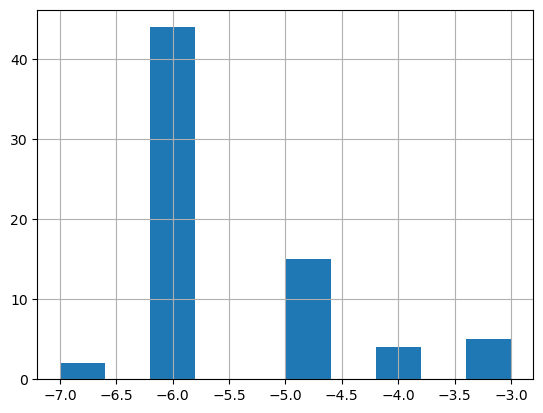

In [11]:
selected_data['delta_pos_charge_base_binder'].hist()

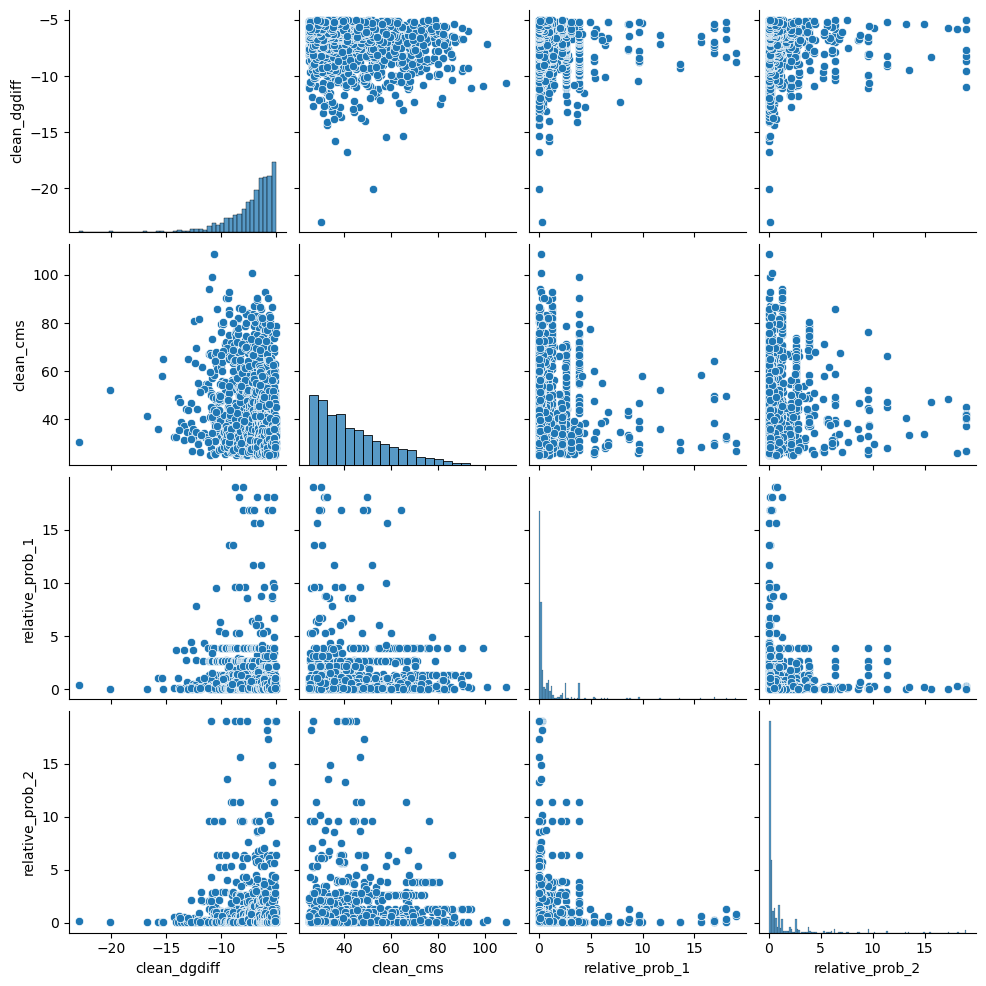

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(data[['clean_dgdiff', 'clean_cms', 'relative_prob_1', 'relative_prob_2']][(data['clean_total_score'] > -40) & (data['relative_prob_1'] < 25) & (data['relative_prob_2'] < 25)])

In [13]:
# three output formats: one with all scaffolds mixed, one per used scaffold and one with recommended sequences
data.to_csv('filtered_results_summary/all_seqs.csv', index=False)
selected_data.to_csv('filtered_results_summary/recommended_seqs.csv')
for scaffold in rosetta_results:
    data[data['scaffold'] == scaffold].to_csv('filtered_results_summary/' + scaffold + '.csv')